# NFT data mining

##  Download the data and store it in a dictionary

In [7]:
import requests
url = "https://terra-classic-fcd.publicnode.com/v1/txs?offset={}&limit=100&account={}"
contract1 = "terra103z9cnqm8psy0nyxqtugg6m7xnwvlkqdzm4s4k"  # galactic punks
offset = 0
msgs = []

while True:
    response = requests.get(url.format(offset, contract1))
    data = response.json()

    # Check if there are transactions in the response
    transactions = data.get("txs", [])

    if not transactions:
        break

    for tx_i in transactions:
        for m in tx_i['tx']['value']['msg']:
            if 'execute_msg' in m['value']:
                message = {
                    'type': m['type'],
                    'hash_id': tx_i['txhash'],
                    'exe_msg': m['value']['execute_msg']
                }
                msgs.append(message)

    cursor = data.get("next")
    
    if cursor:
        offset = cursor
    else:
        break


## Save to file for potential further use.

In [8]:
import json
file_name = 'punks.json'
with open(file_name, 'w') as file:
    json.dump(msgs, file)

## Filter out nfts with "mint_nft" which should contain usefull info.

In [9]:
filtered_msgs = []

for msg in msgs:
    execute_msg = msg.get('exe_msg', '')
    if 'mint_nft' in execute_msg:
        filtered_msgs.append(msg)


## Display filtered messages

In [10]:
filtered_msgs

[{'type': 'wasm/MsgExecuteContract',
  'hash_id': 'BB06CD8CD135E7E8DA6138FD96C659166A6D0ABFED74A6ED68FBCC149BBE54BC',
  'exe_msg': {'mint_nft': {'token_id': '17586352747498878062961518117840408040',
    'extension': {'name': 'Galactic Punk #855',
     'image': 'ipfs://QmSZeCiryPoUCjCgTyUxzrBF9sUheJivfAD4CsbBLW18q5',
     'attributes': [{'value': 'dark spaceship', 'trait_type': 'backgrounds'},
      {'value': 'commander', 'trait_type': 'suits'},
      {'value': 'lunatic 6', 'trait_type': 'species'},
      {'value': 'black eye', 'trait_type': 'face'},
      {'value': 'brown mid', 'trait_type': 'hair'},
      {'value': 'cool punk', 'trait_type': 'glasses'},
      {'value': 'tough punk', 'trait_type': 'headware'}],
     'description': 'Galactic Punks are 10,921 randomly generated NFTs on the Terra blockchain.'},
    'token_uri': 'ipfs://QmW7GSAbG1yZxSMdT4boGFpJCX2Y8Cq7U4z4b1RBaNR59A',
    'reservation_id': 10794}}},
 {'type': 'wasm/MsgExecuteContract',
  'hash_id': 'BB06CD8CD135E7E8DA6138F

## Check what attributes nfts have.

In [11]:
all_attributes = set()
for msg in filtered_msgs:
    attributes = msg['exe_msg']['mint_nft']['extension']['attributes']
    for attr in attributes:
        all_attributes.add(attr['trait_type'])

print("List of all attributes:")
for attribute in all_attributes:
    print(attribute)

List of all attributes:
suits
headware
backgrounds
species
glasses
jewelry
hair
face


## Now it's time to put all of the filtered data into a dataframe.

In [12]:
import pandas as pd


nft_df = pd.DataFrame(columns=['NFT_ID', 'Background', 'Suits', 'Hair', 'Species', 'Face', 'Glasses', 'Headware', 'Jewelry'])

for msg in filtered_msgs:
    nft_name = msg['exe_msg']['mint_nft']['extension']['name']
    nft_number = nft_name.split("#")[-1].strip()  # Extract only the numbers after "#"
    nft_id = f"#{nft_number}"
    transaction_hash = msg['hash_id']
    attributes = msg['exe_msg']['mint_nft']['extension']['attributes']

    background = next((attr['value'] for attr in attributes if attr['trait_type'] == 'backgrounds'), '')
    suits = next((attr['value'] for attr in attributes if attr['trait_type'] == 'suits'), '')
    hair = next((attr['value'] for attr in attributes if attr['trait_type'] == 'hair'), '')
    species = next((attr['value'] for attr in attributes if attr['trait_type'] == 'species'), '')
    face = next((attr['value'] for attr in attributes if attr['trait_type'] == 'face'), '')
    glasses = next((attr['value'] for attr in attributes if attr['trait_type'] == 'glasses'), '')
    headware = next((attr['value'] for attr in attributes if attr['trait_type'] == 'headware'), '')
    jewelry = next((attr['value'] for attr in attributes if attr['trait_type'] == 'jewelry'), '')


    nft_df = nft_df.append({
        'NFT_ID': nft_id,
        'Background': background,
        'Suits': suits,
        'Hair': hair,
        'Species': species,
        'Face': face,
        'Glasses': glasses,
        'Headware': headware,
        'Jewelry': jewelry
    }, ignore_index=True)


In [13]:
print("NFT Characteristics Table:")
nft_df

NFT Characteristics Table:


,NFT_ID,Background,Suits,Hair,Species,Face,Glasses,Headware,Jewelry
0,#855,dark spaceship,commander,brown mid,lunatic 6,black eye,cool punk,tough punk,
1,#4535,red planet,cyberpunk trench,brown neat,lunatic 4,black eye,cyborg assassin,,
2,#7986,night blue,robot,messy blonde,terrarian mars 2,black eye,eyepatch,orange bandana,
3,#7681,ice planet night,og blue,blue messy,lunatic 10,battle wound,,gp tough punk,diamond earring
4,#6503,night blue,gold trim,messy pink,alien 2,face tat,cruise,,
...,...,...,...,...,...,...,...,...,...
10916,#2615,green planet day,black spacesuit,blonde long,terrarian neptune 2,face tat,cyborg blue,tough punk,
10917,#1107,mars,cyberpunk trench,red mullet,lunatic 10,,cyborg blue,transponder red,silver earring and chain
10918,#2434,ice planet,rising floor,blue mid,zombie 1,,speedy blue,golden cap,
10919,#57,green planet night gold,gold trim,blue messy,lunatic 7,face tat,,,diamond earring


## Because of the way we created df, we need to replace empty slots with 0 for analysis.

In [ ]:
import matplotlib.pyplot as plt
traits = ['Background', 'Suits', 'Hair', 'Species', 'Face', 'Glasses', 'Headware', 'Jewelry']
nft_df[traits] = nft_df[traits].replace('', 0)

## Check "rarity" of different attributes.

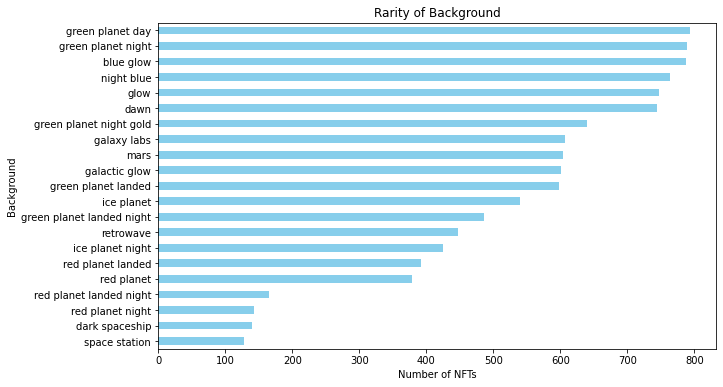

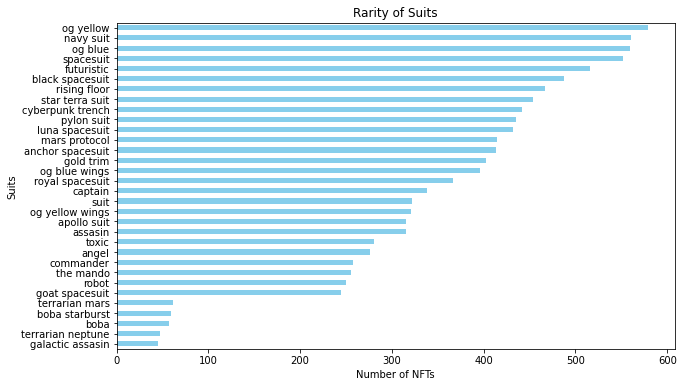

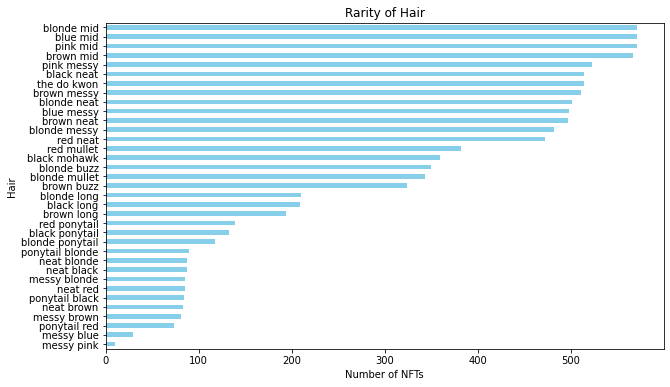

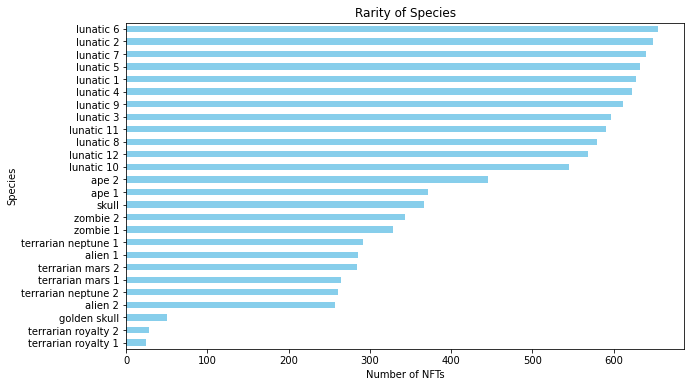

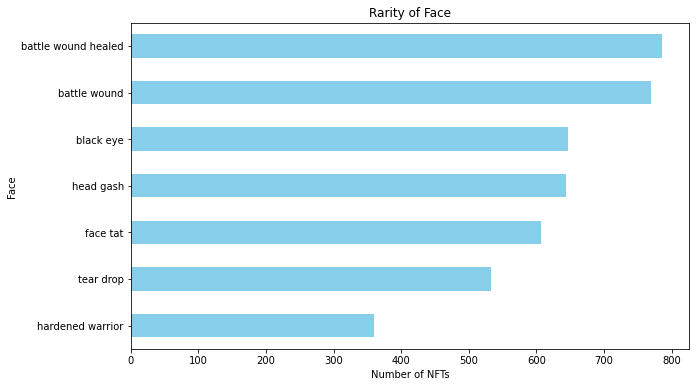

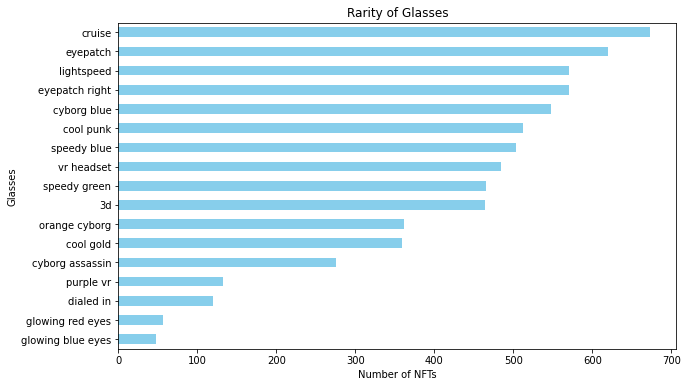

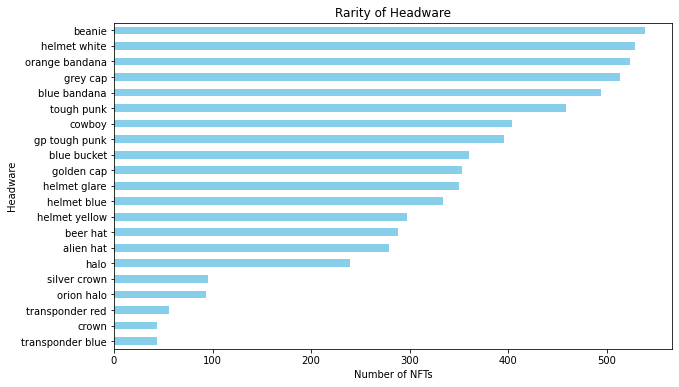

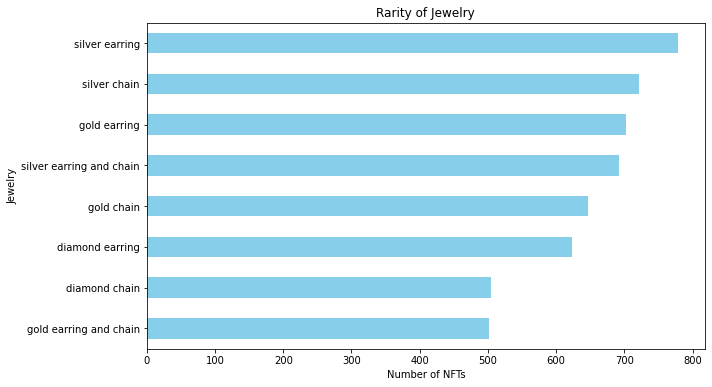

In [15]:
for trait in traits:
    plt.figure(figsize=(10, 6))
    non_zero_values = nft_df[trait][nft_df[trait] != 0]
    non_zero_values.value_counts().sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'Rarity of {trait}')
    plt.xlabel('Number of NFTs')
    plt.ylabel(trait)
    plt.show()



## Check n-grams.

In [20]:
from nltk import ngrams, word_tokenize
import re

text_data = ' '.join(nft_df.iloc[:, 1:].astype(str).agg(' '.join, axis=1))

tokens = word_tokenize(re.sub(r'[\d.]+', '', text_data))

n = 2

n_grams = list(ngrams(tokens, n))

from collections import Counter

most_common_ngrams = Counter(n_grams).most_common()

print(f'Most common {n}-grams:')
for n_gram, count in most_common_ngrams:
    print(f'{n_gram}: {count} occurrences')


Most common 2-grams:
('green', 'planet'): 3306 occurrences
('planet', 'night'): 1997 occurrences
('planet', 'landed'): 1641 occurrences
('messy', 'lunatic'): 1600 occurrences
('battle', 'wound'): 1555 occurrences
('neat', 'lunatic'): 1552 occurrences
('mid', 'lunatic'): 1517 occurrences
('silver', 'earring'): 1471 occurrences
('gold', 'earring'): 1204 occurrences
('earring', 'and'): 1194 occurrences
('and', 'chain'): 1194 occurrences
('red', 'planet'): 1079 occurrences
('lunatic', 'battle'): 1063 occurrences
('ice', 'planet'): 965 occurrences
('og', 'blue'): 955 occurrences
('chain', 'green'): 929 occurrences
('og', 'yellow'): 900 occurrences
('tough', 'punk'): 854 occurrences
('blue', 'glow'): 812 occurrences
('planet', 'day'): 793 occurrences
('wound', 'healed'): 786 occurrences
('night', 'blue'): 763 occurrences
('night', 'gold'): 729 occurrences
('silver', 'chain'): 721 occurrences
('earring', 'green'): 662 occurrences
('landed', 'night'): 651 occurrences
('black', 'eye'): 646 occu

## Now we can apply some rules in order to rank nfts based on the rarity of their attributtes.

In [22]:
attribute_usage = {trait: {} for trait in traits}

for trait in traits:
    attribute_usage[trait] = nft_df[trait].value_counts().to_dict()

attribute_points = {trait: {} for trait in traits}

for trait, usage in attribute_usage.items():
    sorted_attributes = sorted(usage, key=usage.get)
    
    for idx, attribute in enumerate(sorted_attributes[:5]):
        attribute_points[trait][attribute] = 5 - idx

for trait, points in attribute_points.items():
    print(f"{trait} Points:")
    for attribute, point in points.items():
        print(f"  {attribute}: {point} points")


Background Points:
  space station: 5 points
  dark spaceship: 4 points
  red planet night: 3 points
  red planet landed night: 2 points
  red planet: 1 points
Suits Points:
  galactic assasin: 5 points
  terrarian neptune: 4 points
  boba: 3 points
  boba starburst: 2 points
  terrarian mars: 1 points
Hair Points:
  messy pink: 5 points
  messy blue: 4 points
  ponytail red: 3 points
  messy brown: 2 points
  neat brown: 1 points
Species Points:
  terrarian royalty 1: 5 points
  terrarian royalty 2: 4 points
  golden skull: 3 points
  alien 2: 2 points
  terrarian neptune 2: 1 points
Face Points:
  hardened warrior: 5 points
  tear drop: 4 points
  face tat: 3 points
  head gash: 2 points
  black eye: 1 points
Glasses Points:
  glowing blue eyes: 5 points
  glowing red eyes: 4 points
  dialed in: 3 points
  purple vr: 2 points
  cyborg assassin: 1 points
Headware Points:
  crown: 5 points
  transponder blue: 4 points
  transponder red: 3 points
  orion halo: 2 points
  silver crown: 1

In [51]:
nft_df['TotalPoints'] = 0.0

for trait in traits:
    nft_df[f'{trait}Points'] = 0.0

for index, row in nft_df.iterrows():
    total_points = 0.0
    for trait, attribute in zip(traits, row[traits]):
        if attribute in attribute_points[trait]:
            points = attribute_points[trait][attribute]
            total_points += points
            nft_df.at[index, f'{trait}Points'] = points
    
    nft_df.at[index, 'TotalPoints'] = total_points

columns_to_display = ['NFT_ID', 'TotalPoints'] + [f'{trait}Points' for trait in traits]
print(nft_df[columns_to_display].sort_values(by='TotalPoints', ascending=False).head(10))


      NFT_ID  TotalPoints  BackgroundPoints  SuitsPoints  HairPoints  \
10203  #6862         15.0               0.0          4.0         0.0   
3334    #441         15.0               0.0          0.0         0.0   
1737   #4911         15.0               0.0          5.0         0.0   
7461   #3466         15.0               3.0          0.0         0.0   
1089   #1318         14.0               0.0          0.0         0.0   
1567   #3720         14.0               0.0          0.0         2.0   
2465   #8592         14.0               0.0          0.0         0.0   
5884    #338         14.0               3.0          0.0         4.0   
7104   #3632         14.0               0.0          4.0         0.0   
5886   #4821         13.0               5.0          0.0         0.0   

       SpeciesPoints  FacePoints  GlassesPoints  HeadwarePoints  JewelryPoints  
10203            0.0         3.0            3.0             2.0            3.0  
3334             5.0         5.0            0

In [48]:
nft_df['TotalPoints'] = 0.0

for trait in traits:
    nft_df[f'{trait}Points'] = 0.0

for index, row in nft_df.iterrows():
    total_points = 0.0
    
    for trait, attribute in zip(traits, row[traits]):
        if attribute in attribute_points[trait]:
            points = attribute_points[trait][attribute]
            total_points += points
            
            nft_df.at[index, f'{trait}Points'] = points
    
    num_attributes_with_points = sum(1 for trait in traits if nft_df.at[index, f'{trait}Points'] > 0)
    average_points = total_points / num_attributes_with_points if num_attributes_with_points > 0 else 0.0
    nft_df.at[index, 'TotalPoints'] = average_points
    nft_df.at[index, 'NonZeroCategories'] = num_attributes_with_points

columns_to_display = ['NFT_ID', 'TotalPoints', 'NonZeroCategories'] + [f'{trait}Points' for trait in traits]
sorted_nft_df = nft_df.sort_values(by=['TotalPoints', 'NonZeroCategories'], ascending=[False, False])
print(sorted_nft_df[columns_to_display].head(10))

      NFT_ID  TotalPoints  NonZeroCategories  BackgroundPoints  SuitsPoints  \
3334    #441          5.0                3.0               0.0          0.0   
171    #3262          5.0                2.0               0.0          0.0   
1131   #8484          5.0                2.0               5.0          0.0   
2119  #10307          5.0                2.0               5.0          0.0   
2150   #5503          5.0                2.0               0.0          0.0   
2209   #3982          5.0                2.0               0.0          0.0   
3233   #4834          5.0                2.0               0.0          0.0   
3418   #5988          5.0                2.0               0.0          0.0   
4199  #10873          5.0                2.0               0.0          0.0   
5032   #4471          5.0                2.0               5.0          5.0   

      HairPoints  SpeciesPoints  FacePoints  GlassesPoints  HeadwarePoints  \
3334         0.0            5.0         5.0         

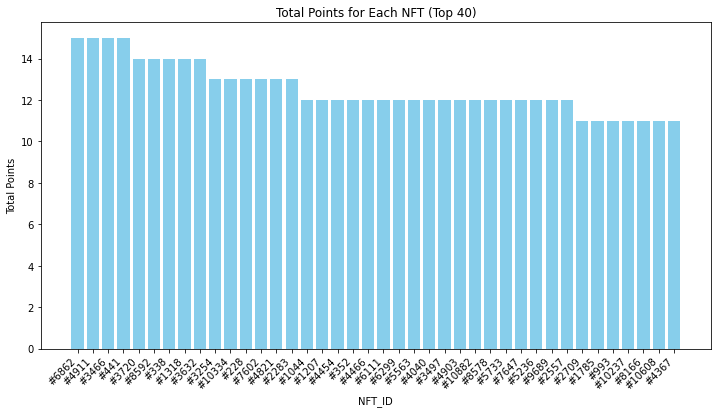

In [58]:
import matplotlib.pyplot as plt

filtered_nft_df = nft_df[nft_df['TotalPoints'] > 0]

sorted_nft_df = filtered_nft_df.sort_values(by='TotalPoints', ascending=False)

limited_nft_df = sorted_nft_df.head(40)

plt.figure(figsize=(12, 6))
plt.bar(limited_nft_df['NFT_ID'], limited_nft_df['TotalPoints'], color='skyblue')
plt.title('Total Points for Each NFT (Top 40)')
plt.xlabel('NFT_ID')
plt.ylabel('Total Points')
plt.xticks(rotation=45, ha='right')
plt.show()

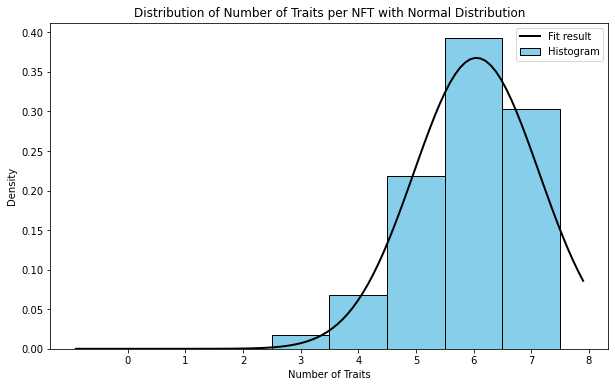

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

nft_df['NumTraits'] = nft_df[traits].apply(lambda x: x[x != 0].count(), axis=1)

plt.figure(figsize=(10, 6))
plt.hist(nft_df['NumTraits'], bins=np.arange(0, 9) - 0.5, color='skyblue', edgecolor='black', density=True)

mu, sigma = nft_df['NumTraits'].mean(), nft_df['NumTraits'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Distribution of Number of Traits per NFT with Normal Distribution')
plt.xlabel('Number of Traits')
plt.ylabel('Density')
plt.xticks(np.arange(0, 9))
plt.legend(['Fit result', 'Histogram'])
plt.show()

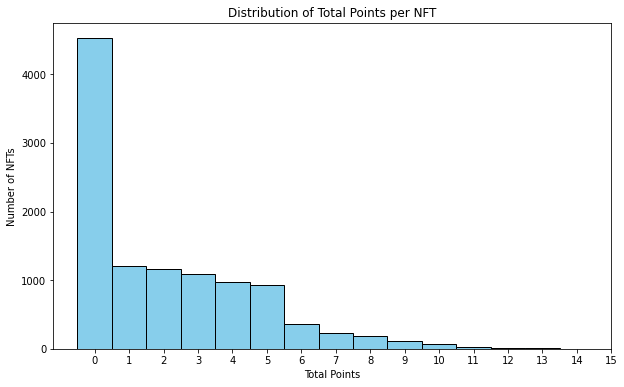

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

points_data = nft_df['TotalPoints']

plt.figure(figsize=(10, 6))
plt.hist(points_data, bins=np.arange(0, 15) - 0.5, color='skyblue', edgecolor='black', density=False)

plt.title('Distribution of Total Points per NFT')
plt.xlabel('Total Points')
plt.ylabel('Number of NFTs')
plt.xticks(np.arange(0, 16))
plt.show()